In [1]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
import IPython
from matplotlib.ticker import MaxNLocator
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

### Data

In [3]:
#32 H(z) data
filename = 'cc_mock.txt'
zhzi, hzi, shzi = np.genfromtxt(filename, comments='#', dtype=None, usecols=(0, 1, 2), unpack=True)
#number of data
ndata = len(zhzi)

In [2]:

fullspec_hzi = []
fullspec_zhzi = []
fullspec_shzi = []

dbreak_hzi = []
dbreak_zhzi = []
dbreak_shzi = []

for i in range(ndata):
    if method[i] == "F":
        fullspec_hzi.append(hzi[i])
        fullspec_zhzi.append(zhzi[i])
        fullspec_shzi.append(shzi[i])
    elif method[i] == "D":
        dbreak_hzi.append(hzi[i])
        dbreak_zhzi.append(zhzi[i])
        dbreak_shzi.append(shzi[i])

dbreak_hzi = np.array(dbreak_hzi)
dbreak_zhzi = np.array(dbreak_zhzi)
dbreak_shzi = np.array(dbreak_shzi)

fullspec_hzi = np.array(fullspec_hzi)
fullspec_zhzi = np.array(fullspec_zhzi)
fullspec_shzi = np.array(fullspec_shzi)

### Some default configurations

In [4]:
pl.rcParams['text.usetex'] = True
pl.rcParams.update(pl.rcParamsDefault)
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2]])
nstepHz = 10000

### Analysis functions

In [8]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865525393149998], axis=0)[0]
    par_valp = np.percentile(samples, [84.13447460685], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label=r"$h _{\nu}$")
    pl.plot(chiv, y, '--', label=r"$\chi _{\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel(r'$h_{\nu}$')
    pl.xlabel(r'$\chi _{\nu} ^{2}$')
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

## Computing the covariance matrix

In [7]:
cov_mat = np.loadtxt('cov_mock.txt')
inv_cov = linalg.inv(cov_mat)

In [8]:
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

f_data = len(fullspec_hzi)
d_data = len(dbreak_hzi)

f_cov_mat_diag = np.zeros((f_data, f_data), dtype='float64')
d_cov_mat_diag = np.zeros((d_data, d_data), dtype='float64')

for i in range(f_data):
    f_cov_mat_diag[i,i] = fullspec_shzi[i]**2

for i in range(d_data):
    d_cov_mat_diag[i,i] = dbreak_shzi[i]**2

fullspec_imf_intp = np.interp(fullspec_zhzi, zmod, imf)/100
fullspec_spsooo_intp = np.interp(fullspec_zhzi, zmod, spsooo)/100

dbreak_imf_intp = np.interp(dbreak_zhzi, zmod, imf)/100
dbreak_spsooo_intp = np.interp(dbreak_zhzi, zmod, spsooo)/100

f_cov_mat_imf = np.zeros((f_data, f_data), dtype='float64')
f_cov_mat_spsooo = np.zeros((f_data, f_data), dtype='float64')

d_cov_mat_imf = np.zeros((d_data, d_data), dtype='float64')
d_cov_mat_spsooo = np.zeros((d_data, d_data), dtype='float64')

for i in range(f_data):
    for j in range(f_data):
        f_cov_mat_imf[i,j] = fullspec_hzi[i] * fullspec_imf_intp[i] * fullspec_hzi[j] * fullspec_imf_intp[j]
        f_cov_mat_spsooo[i,j] = fullspec_hzi[i] * fullspec_spsooo_intp[i] * fullspec_hzi[j] * fullspec_spsooo_intp[j]

for i in range(d_data):
    for j in range(d_data):
        d_cov_mat_imf[i,j] = dbreak_hzi[i] * dbreak_imf_intp[i] * dbreak_hzi[j] * dbreak_imf_intp[j]
        d_cov_mat_spsooo[i,j] = dbreak_hzi[i] * dbreak_spsooo_intp[i] * dbreak_hzi[j] * dbreak_spsooo_intp[j]

f_cov_mat = f_cov_mat_imf + f_cov_mat_spsooo + f_cov_mat_diag
f_inv_cov = linalg.inv(f_cov_mat)

d_cov_mat = d_cov_mat_imf + d_cov_mat_spsooo + d_cov_mat_diag
d_inv_cov = linalg.inv(d_cov_mat)

# Uncorrected LCDM with curvature

In [14]:
par_HzC = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
ndimC = len(par_HzC)
prefixC = 'LcdmHz32Cov'
parlabelsC = ["H_0","\\Omega_m", "\\Omega_\\Lambda"]
parlabtexC = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$"]
parnamesC = ['H0','wm','wl']

resultHzC = find_bestfit(lnprobHz, par_HzC, parnamesC, freef=False, flat=False)
par_HzC = resultHzC['x']

Maximum likelihood result:
H0  =  66.75238187431387
wm  =  3.3194965319435506e-09
wl  =  0.08656101904700808
chi2min = 7.359308554562346
Total time: 0.030 seg


C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [15]:
samplerHzC = run_emcee(par_HzC, 100, lnprobHz, False, False, 2.0, nstepHz)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 151.53it/s]

Acceptance fraction: [0.594  0.6024 0.5777 0.5901 0.5885 0.6037 0.5919 0.5906 0.5897 0.5919
 0.5739 0.5954 0.5921 0.5832 0.5907 0.6018 0.6016 0.5847 0.5984 0.6017
 0.5913 0.597  0.5782 0.5838 0.6004 0.5963 0.586  0.6069 0.5929 0.6025
 0.5813 0.5875 0.601  0.6114 0.5892 0.5888 0.6041 0.587  0.594  0.5941
 0.589  0.5904 0.5926 0.5953 0.5881 0.605  0.5849 0.5999 0.6048 0.5969
 0.5931 0.5954 0.5908 0.5878 0.5915 0.5982 0.6036 0.5778 0.5862 0.5946
 0.5817 0.5872 0.5897 0.5916 0.6039 0.5926 0.5901 0.5779 0.5975 0.5851
 0.5803 0.5858 0.5845 0.5913 0.5953 0.5915 0.6035 0.5925 0.5898 0.6052
 0.6013 0.5971 0.5886 0.5955 0.5922 0.5861 0.5926 0.5858 0.591  0.5925
 0.6025 0.5784 0.5908 0.5964 0.596  0.5776 0.598  0.5932 0.59   0.5874]
Minimum acceptance: 0.5739
Maximum acceptance: 0.6114


In [16]:
tauHzC = samplerHzC.get_autocorr_time()
print(tauHzC)

tauHzmaxC = np.amax(tauHzC)
r = nstepHz/tauHzmaxC
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[50.92099203 49.72889513 53.49649679]
186.9281280032178
Convergiu! :)


In [17]:
samplesHzC = burninthin(samplerHzC, 100)

(19600, 3)


In [18]:
MC_result(samplesHzC, par_HzC, parnamesC)

MCMC result:
H0 = 68.22495 +9.33497 +19.26244 -9.60563 -16.33414 (median: 67.90296, ml: 66.75238)
wm = 0.30693 +0.23362 +0.52817 -0.22839 -0.29634 (median: 0.26339, ml: 0.00000)
wl = 0.58133 +0.55062 +1.09090 -0.52435 -1.03570 (median: 0.55655, ml: 0.08656)


In [19]:
gsamplesHzC = MCSamples(samples=samplesHzC, names=parnamesC, labels=parlabelsC, ranges={'wm':(0, None)})
gsamplesHzC.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


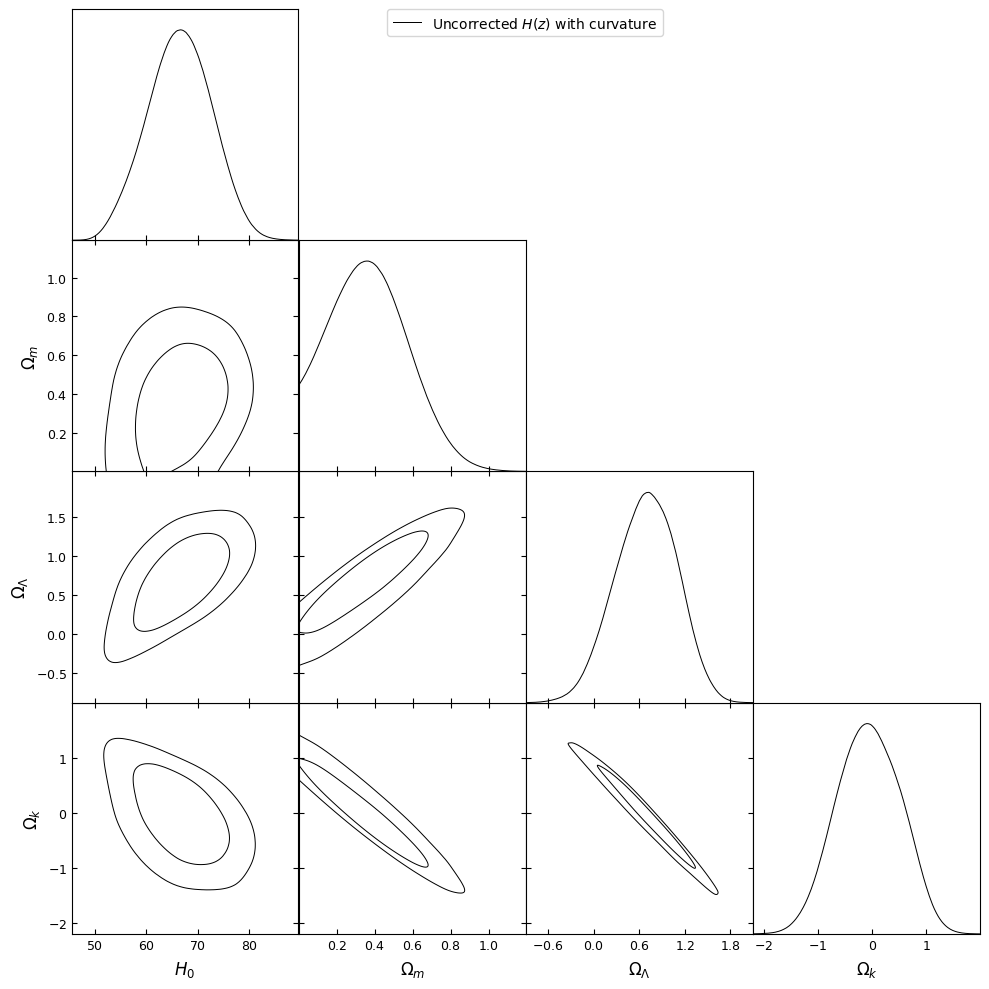

In [64]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixC+'All-triangle.pdf')

In [26]:
samplesHzC, gsamplesHzC, parnamesC, ndim = insertDerived(samplesHzC, parnamesC, parlabelsC, 4, gsamplesHzC, 1 - gsamplesHzC.getParams().wm - gsamplesHzC.getParams().wl, 'wk', '\\Omega_k')

In [27]:
MC_result(samplesHzC, ndim, parnamesC)

MCMC result:
H0 = 66.48500 +6.33444 +12.13002 -6.37384 -12.48137 (median: 66.51877, ml: 0.00000)
wm = 0.37251 +0.20722 +0.42029 -0.21489 -0.34633 (median: 0.36384, ml: 0.00000)
wl = 0.68776 +0.41260 +0.76689 -0.41681 -0.81818 (median: 0.69710, ml: 0.00000)
wk = -0.06027 +0.61121 +1.11601 -0.59873 -1.14958 (median: -0.06043, ml: 0.00000)


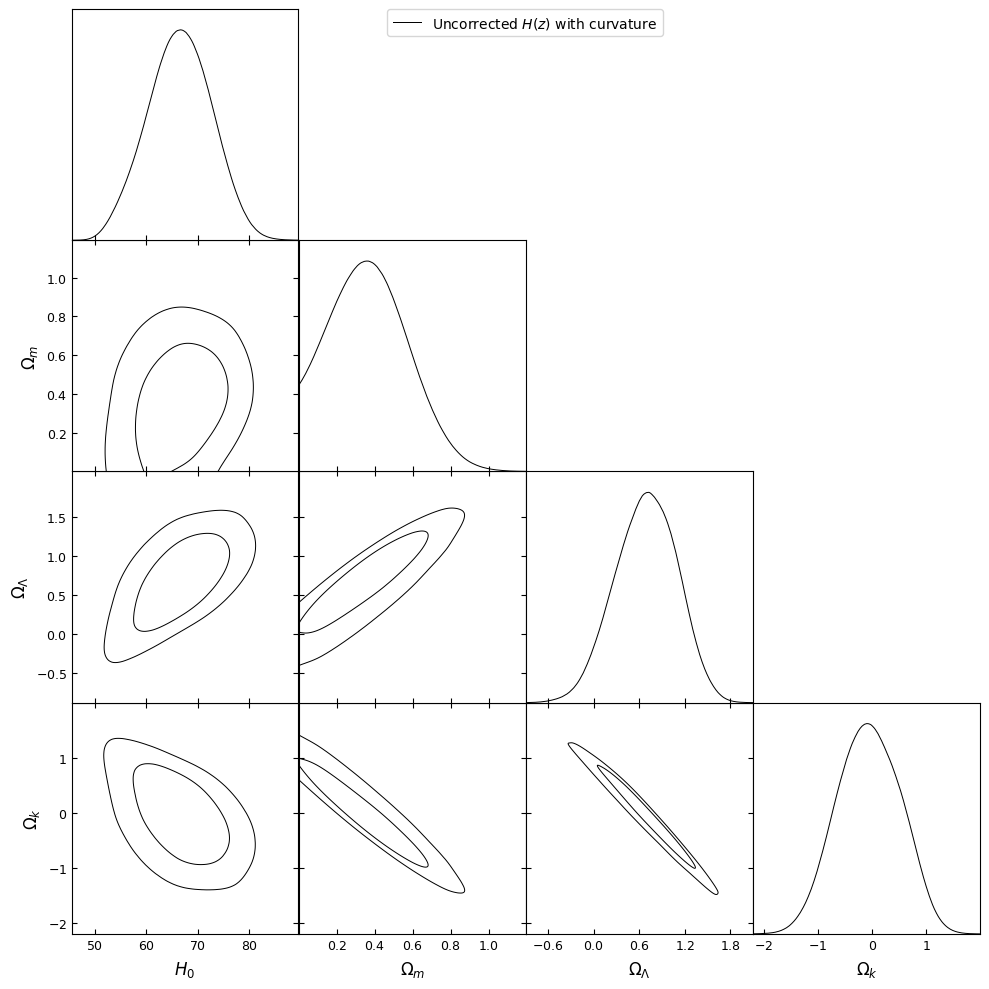

In [28]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixC+'All-triangle_Wk.pdf')

In [29]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzC.getInlineLatex(parnamesC[i],limit=j))
        
print(gsamplesHzC.getTable().tableTex())

H_0 = 66.5\pm 6.2
H_0 = 66^{+10}_{-10}
H_0 = 66^{+10}_{-10}
\Omega_m = 0.37^{+0.18}_{-0.24}
\Omega_m < 0.723
\Omega_m < 0.868
\Omega_\Lambda = 0.69^{+0.44}_{-0.38}
\Omega_\Lambda = 0.69^{+0.75}_{-0.81}
\Omega_\Lambda = 0.69^{+0.95}_{-1.1}
\Omega_k = -0.06\pm 0.58
\Omega_k = -0.1^{+1.1}_{-1.1}
\Omega_k = -0.1^{+1.4}_{-1.4}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.723                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


In [30]:
print(types.ResultTable(ncol=1,results=gsamplesHzC, paramList=parnamesC, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.723                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


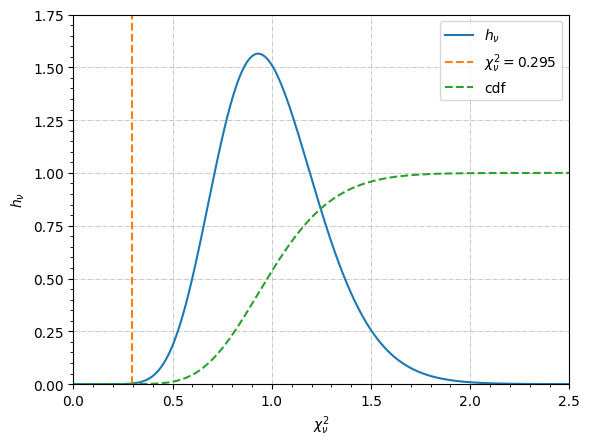

Probabilidade =  0.008145420657137428
Chiv =  0.2952837455896827


In [20]:
chi2mC = chi2Hz(free_par([66.60620, 0.37645, 0.69908], freef=False, flat=False))
chivCperc, errF = quad(chiDist, 0, chi2mC/(ndata-len(par_HzC)), args=(ndata-len(par_HzC)))
plotChiDist(chi2mC, len(par_HzC))
print('Probabilidade = ', chivCperc*100)
print('Chiv = ', chi2mC/(ndata-len(par_HzC)))

# Corrected LCDM with curvature

In [7]:
par_HzCF = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9]
ndimCF = len(par_HzCF)
prefixCF = 'LcdmHz32Cov'
parlabelsCF = ["H_0","\\Omega_m", "\\Omega_\\Lambda", "f"]
parlabtexCF = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$", "$f$"]
parnamesCF = ['H0','wm','wl', 'f']

resultHzCF = find_bestfit(lnprobHz, par_HzCF, parnamesCF, freef=True, flat=False)
par_HzCF = resultHzCF['x']

Maximum likelihood result:
H0  =  68.43573467548853
wm  =  0.37467105254039906
wl  =  0.7837200228628217
f  =  0.6725718558132805
chi2min = 6.614634248192143
Total time: 0.019 seg


In [8]:
samplerHzCF = run_emcee(par_HzCF, 100, lnprobHz, True, False, 2.0, nstepHz)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 147.10it/s]

Acceptance fraction: [0.5824 0.5854 0.5786 0.5802 0.5912 0.5718 0.5726 0.5782 0.5834 0.5874
 0.5748 0.583  0.579  0.578  0.5666 0.5862 0.5992 0.5836 0.5762 0.5896
 0.5946 0.5856 0.58   0.5776 0.5938 0.5874 0.5838 0.5904 0.5858 0.5846
 0.5868 0.5858 0.581  0.6104 0.5764 0.5872 0.5908 0.5972 0.5808 0.5862
 0.5694 0.5968 0.5894 0.584  0.593  0.5812 0.5804 0.5942 0.5924 0.5902
 0.579  0.5824 0.5792 0.5778 0.5978 0.5768 0.5706 0.57   0.578  0.5826
 0.5752 0.5772 0.5868 0.5826 0.5856 0.586  0.5744 0.5738 0.5806 0.5812
 0.5874 0.586  0.5798 0.5832 0.5876 0.582  0.5836 0.5774 0.5848 0.5774
 0.594  0.5814 0.5908 0.5872 0.5762 0.5864 0.5776 0.5774 0.5962 0.5862
 0.5762 0.5824 0.584  0.5896 0.5952 0.578  0.5962 0.581  0.5844 0.579 ]
Minimum acceptance: 0.5666
Maximum acceptance: 0.6104


In [9]:
tauHzCF = samplerHzCF.get_autocorr_time()
print(tauHzCF)

tauHzmaxCF = np.amax(tauHzCF)
r = nstepHz/tauHzmaxCF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[46.554432   47.39655893 47.06174871 47.54761566]
105.15774409172826
Convergiu! :)


In [10]:
samplesHzCF = burninthin(samplerHzCF, 100)

(9600, 4)


In [11]:
MC_result(samplesHzCF, par_HzCF, parnamesCF)

MCMC result:
H0 = 67.11391 +4.72074 +9.44498 -4.75346 -9.82122 (median: 67.15582, ml: 68.43573)
wm = 0.35789 +0.15761 +0.32332 -0.16460 -0.30640 (median: 0.35932, ml: 0.37467)
wl = 0.70170 +0.32256 +0.59682 -0.32424 -0.68437 (median: 0.72055, ml: 0.78372)
f = 0.73762 +0.09542 +0.23947 -0.09940 -0.17180 (median: 0.72669, ml: 0.67257)


In [12]:
gsamplesHzCF = MCSamples(samples=samplesHzCF, names=parnamesCF, labels=parlabelsCF, ranges={'wm':(0, None)})
gsamplesHzCF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


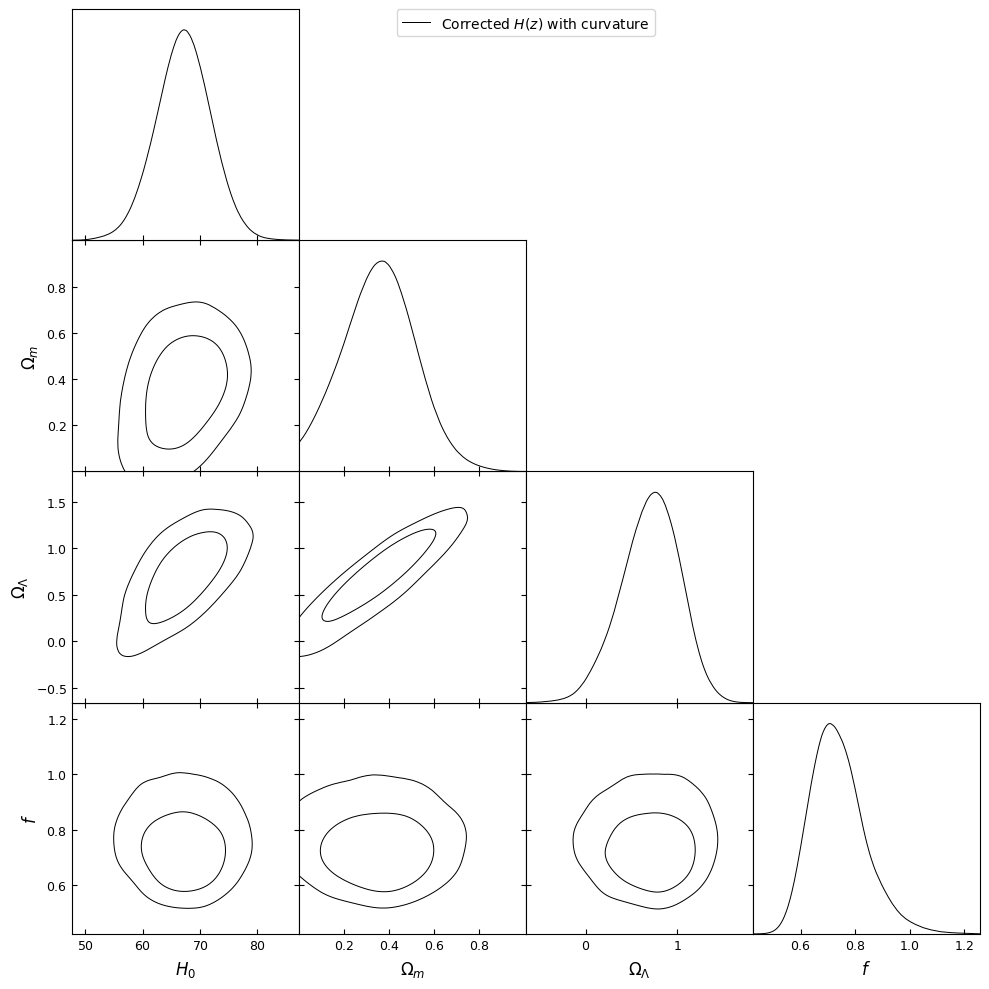

In [13]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixCF+'All-triangle.pdf')

In [14]:
samplesHzCF1, gsamplesHzCF1, parnamesCF1, ndimCF1 = insertDerived(samplesHzCF, parnamesCF, parlabelsCF, 5, gsamplesHzCF, 1 - gsamplesHzCF.getParams().wm - gsamplesHzCF.getParams().wl, 'wk', '\\Omega_k')

In [15]:
MC_result(samplesHzCF1, ndimCF1, parnamesCF1)

MCMC result:
H0 = 67.11391 +4.72074 +9.44498 -4.75346 -9.82122 (median: 67.15582, ml: 0.00000)
wm = 0.35789 +0.15761 +0.32332 -0.16460 -0.30640 (median: 0.35932, ml: 0.00000)
wl = 0.70170 +0.32256 +0.59682 -0.32424 -0.68437 (median: 0.72055, ml: 0.00000)
f = 0.73762 +0.09542 +0.23947 -0.09940 -0.17180 (median: 0.72669, ml: 0.00000)
wk = -0.05958 +0.47586 +0.95068 -0.46784 -0.88474 (median: -0.07815, ml: 0.00000)


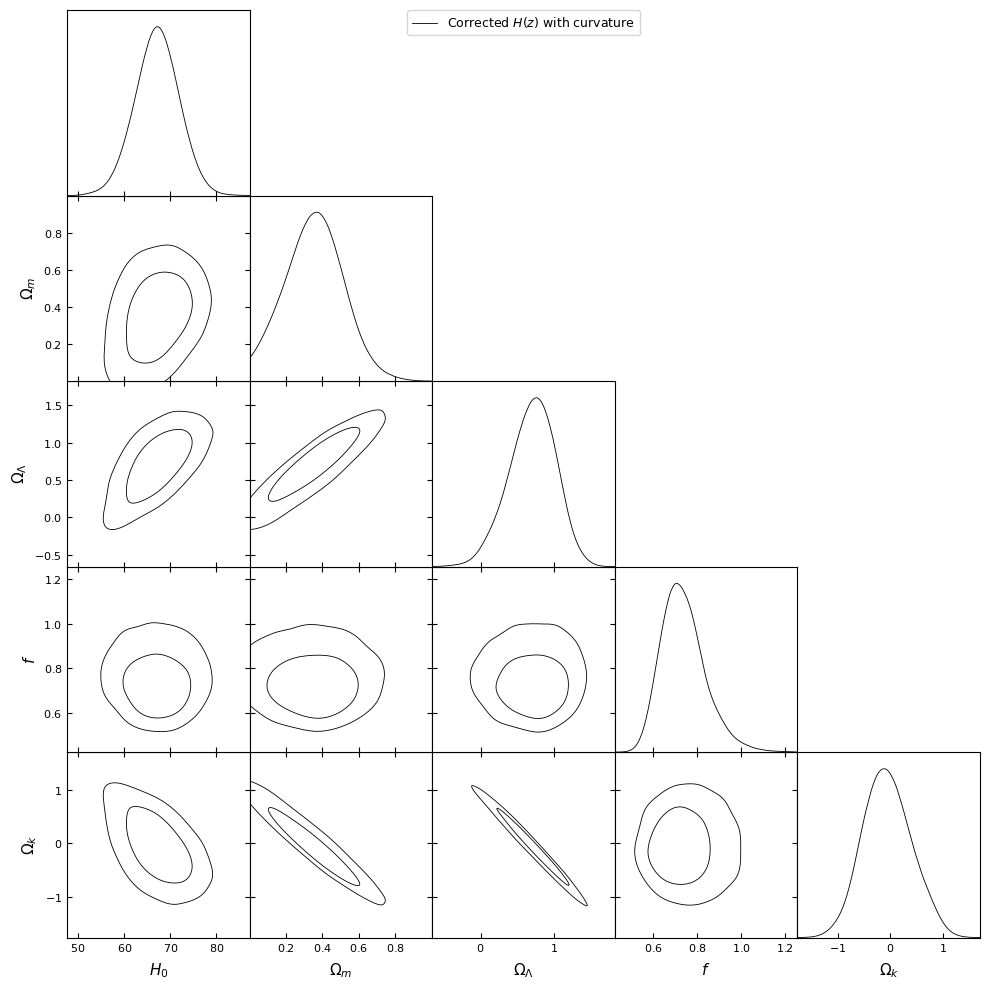

In [16]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF1], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixCF+'All-triangle_Wk.pdf')

In [17]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzCF.getInlineLatex(parnamesCF[i],limit=j))
        
print(gsamplesHzCF.getTable().tableTex())

NameError: name 'ndim' is not defined

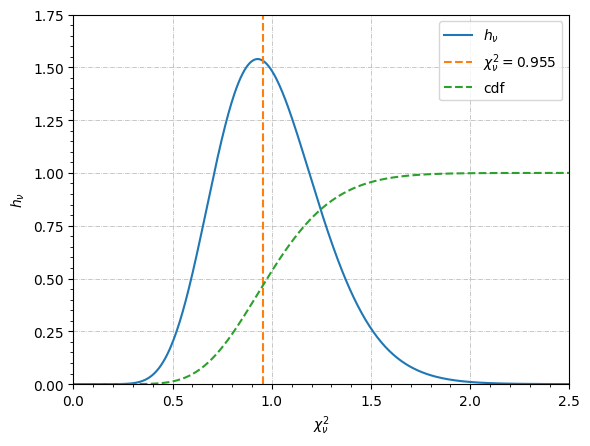

Probabilidade =  46.81143717555001
Chiv =  0.9553601869454954


In [18]:
chi2CF=chi2Hz(free_par([67.16828,0.36434,0.71192,0.73771], freef=True, flat=False))
plotChiDist(chi2CF, len(par_HzCF), name='chi2OLCDM')
chivCFperc, errF = quad(chiDist, 0, chi2CF/(ndata-len(par_HzCF)), args=(ndata-len(par_HzCF)))
print('Probabilidade = ', chivCFperc*100)
print('Chiv = ', chi2CF/(ndata-len(par_HzCF)))

# Comparison between corrected and uncorrected H(z) with curvature

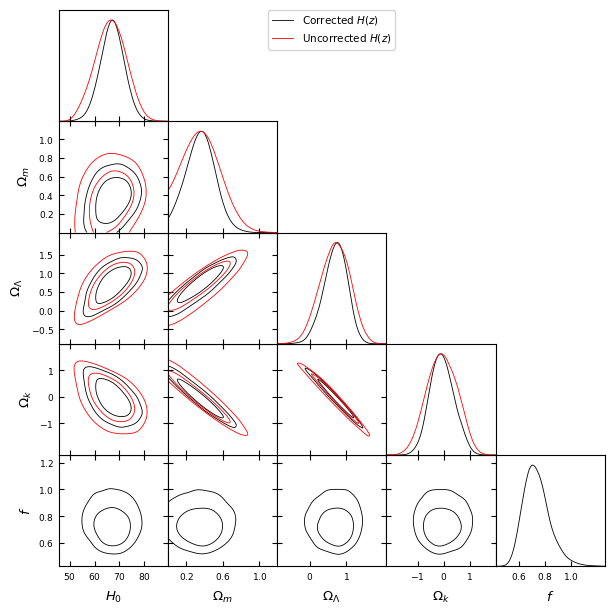

In [65]:
g = plots.getSubplotPlotter(subplot_size=1.25)
g.triangle_plot([gsamplesHzCF1, gsamplesHzC], [parnamesCF[0],parnamesCF[1],parnamesCF[2],parnamesCF[4],parnamesCF[3]],filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gcompUncCorrAll-triangle.pdf')
pl.show()

# Uncorrected Flat LCDM

In [9]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  63.15881806960962
wm  =  0.3417369952857731
chi2min = 47.25724553055255
Total time: 0.026 seg


In [10]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, 10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.84it/s]

Acceptance fraction: [0.6571 0.6605 0.644  0.6583 0.6523 0.6576 0.6519 0.6561 0.6521 0.6508
 0.6353 0.6598 0.6519 0.644  0.6471 0.6529 0.6535 0.6394 0.6568 0.6538
 0.6568 0.6532 0.6339 0.6482 0.6433 0.6539 0.6535 0.6526 0.6424 0.6509
 0.6393 0.654  0.6489 0.6672 0.6476 0.6496 0.6613 0.6473 0.6503 0.6524
 0.6453 0.6511 0.6525 0.6574 0.641  0.6664 0.6455 0.6547 0.6524 0.6573
 0.6552 0.6464 0.6509 0.6597 0.6432 0.6473 0.6578 0.6533 0.6479 0.6502
 0.6444 0.645  0.656  0.6361 0.6619 0.6557 0.6608 0.6416 0.6548 0.6487
 0.6344 0.6421 0.6468 0.6423 0.6488 0.6446 0.6516 0.6546 0.6635 0.6631
 0.6477 0.6472 0.6527 0.655  0.6538 0.6467 0.6439 0.6373 0.6392 0.6548
 0.6519 0.6448 0.6596 0.6579 0.6479 0.6496 0.6472 0.6422 0.6621 0.6389]
Minimum acceptance: 0.6339
Maximum acceptance: 0.6672


In [11]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[51.9885083  51.86942396]
192.35020058225112
Convergiu! :)


In [12]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(39500, 2)


In [13]:
#Full spectrum
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 64.93149 +10.70571 +24.05858 -10.66556 -14.29166 (median: 63.35282, ml: 69.19300)
wm = 0.34403 +0.08677 +0.14991 -0.08339 -0.13797 (median: 0.33984, ml: 0.24809)


In [45]:
#D4000
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 65.89627 +5.71206 +11.22398 -5.75579 -11.60881 (median: 65.92120, ml: 69.19300)
wm = 0.36977 +0.10447 +0.25652 -0.10583 -0.17753 (median: 0.35608, ml: 0.24809)


In [14]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


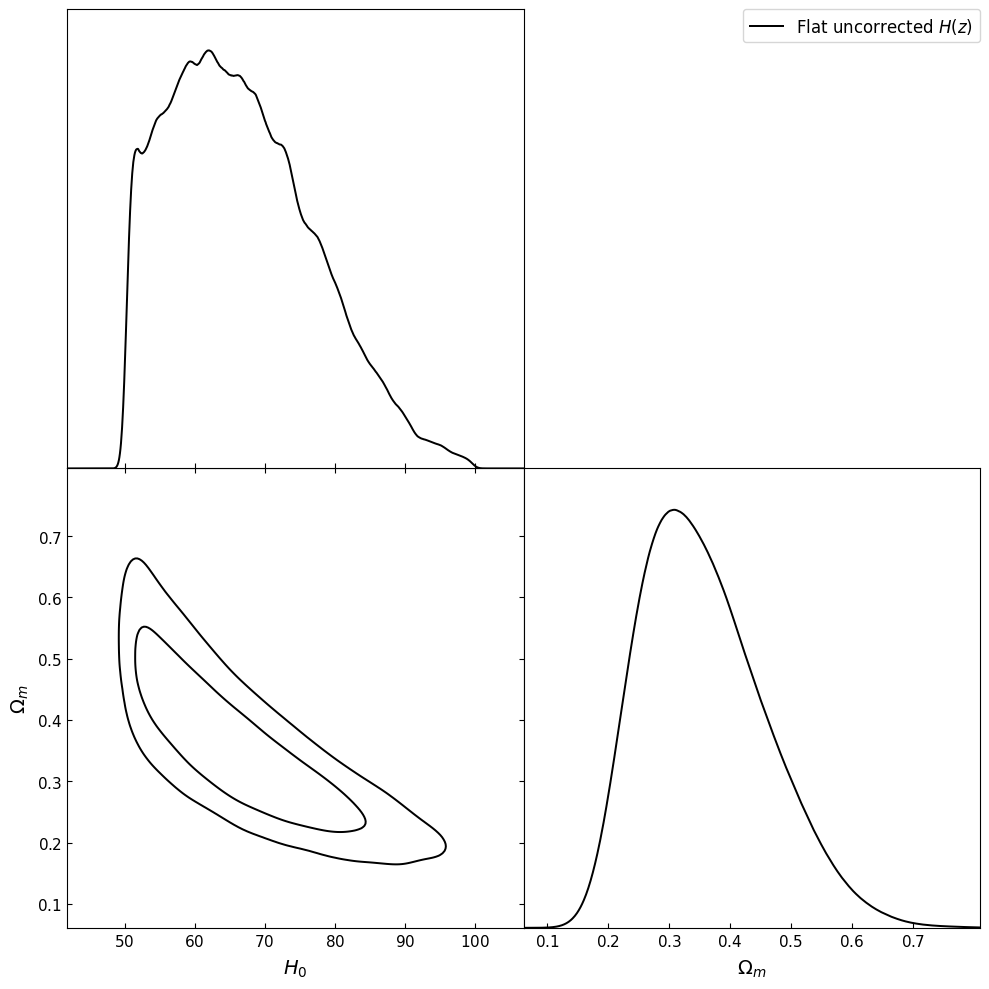

In [12]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle.pdf')

In [15]:
samplesHzF, gsamplesHzF, parnamesF, ndim = insertDerived(samplesHzF, parnamesF, parlabelsF, 3, gsamplesHzF, 1 - gsamplesHzF.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [16]:
#Full spectrum
MC_result(samplesHzF, ndim, parnamesF)

MCMC result:
H0 = 64.93149 +10.70571 +24.05858 -10.66556 -14.29166 (median: 63.35282, ml: 0.00000)
wm = 0.34403 +0.08677 +0.14991 -0.08339 -0.13797 (median: 0.33984, ml: 0.00000)
wl = 0.65597 +0.08339 +0.13797 -0.08677 -0.14991 (median: 0.66016, ml: 0.00000)


In [48]:
#D4000
MC_result(samplesHzF, ndim, parnamesF)

MCMC result:
H0 = 65.89627 +5.71206 +11.22398 -5.75579 -11.60881 (median: 65.92120, ml: 0.00000)
wm = 0.36977 +0.10447 +0.25652 -0.10583 -0.17753 (median: 0.35608, ml: 0.00000)
wl = 0.63023 +0.10583 +0.17753 -0.10447 -0.25652 (median: 0.64392, ml: 0.00000)


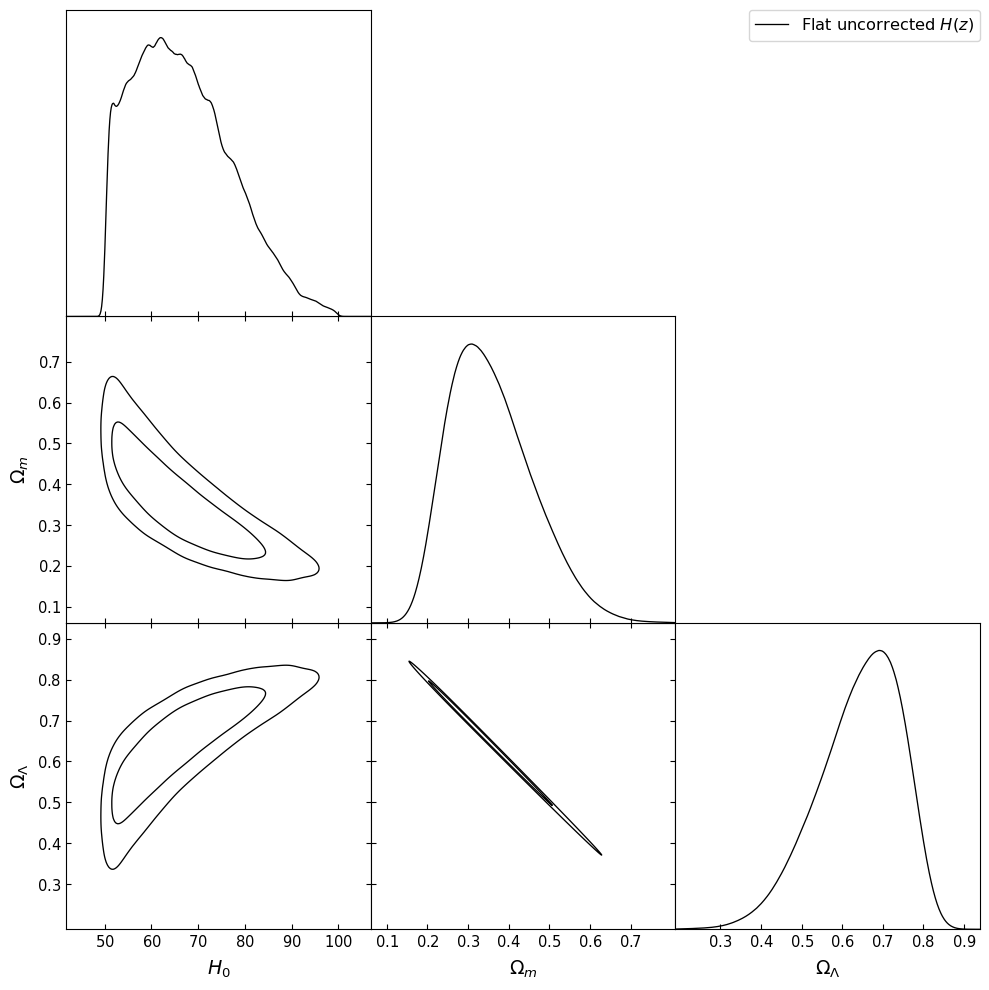

In [16]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle_Wl.pdf')

In [60]:
for i in range(ndimF+1):
    for j in range(1,4):
        print(gsamplesHzF.getInlineLatex(parnamesF[i],limit=j))
        
print(gsamplesHzF.getTable().tableTex())

H_0 = 66.7\pm 5.5
H_0 = 67^{+10}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.342^{+0.054}_{-0.084}
\Omega_m = 0.34^{+0.15}_{-0.13}
\Omega_m = 0.34^{+0.24}_{-0.15}
\Omega _{\Lambda} = 0.658^{+0.084}_{-0.054}
\Omega _{\Lambda} = 0.66^{+0.13}_{-0.15}
\Omega _{\Lambda} = 0.66^{+0.15}_{-0.24}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


In [61]:
print(types.ResultTable(ncol=1,results=gsamplesHzF, paramList=parnamesF, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


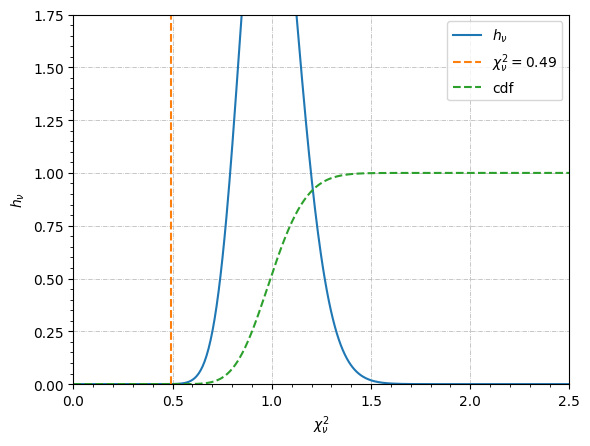

Probabilidade =  0.0005014839431155806
Chiv =  0.4897807579391348


In [26]:
#Full spectrum +10.70571 +24.05858 -10.66556 -14.29166 (median: 63.35282, ml: 0.00000)
chi2F=chi2Hz(free_par([64.93149,0.34403], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF))
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

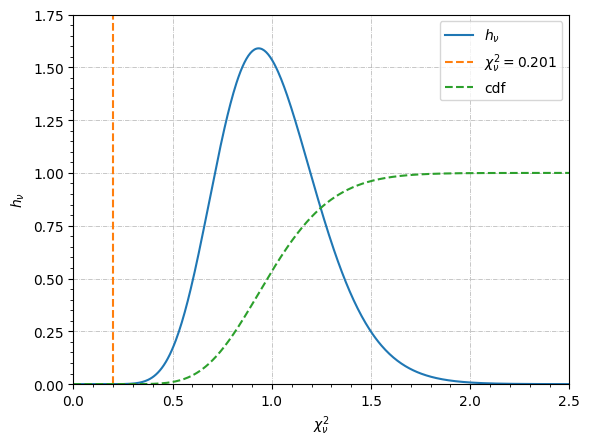

Probabilidade =  5.505886483424682
Chiv =  0.46408223763315876


In [64]:
#D4000
chi2F=chi2Hz(free_par([65.89627,0.36977], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF))
chivFperc, errF = quad(chiDist, 0, chi2F/(d_data-len(par_HzF)), args=(d_data-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(d_data-len(par_HzF)))

# Corrected Flat LCDM

In [29]:
par_HzFf = [69.1929957609451,0.2480895086492853, .5]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  63.158853051450066
wm  =  0.3417367104932473
f  =  0.6874390388831396
chi2min = 25.04358007576778
Total time: 0.020 seg


In [30]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, 10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:28<00:00, 113.48it/s]

Acceptance fraction: [0.595  0.5914 0.578  0.5921 0.5929 0.6015 0.5903 0.6085 0.592  0.598
 0.5814 0.592  0.5885 0.5881 0.594  0.6067 0.6025 0.5902 0.5963 0.5901
 0.6036 0.5907 0.5826 0.5905 0.5894 0.5924 0.5864 0.595  0.6035 0.5936
 0.5814 0.6016 0.5958 0.6002 0.5972 0.5849 0.5982 0.5845 0.5894 0.5879
 0.5856 0.5795 0.6003 0.5959 0.5991 0.5954 0.5888 0.5909 0.5977 0.6031
 0.5931 0.5931 0.5966 0.5927 0.5968 0.5884 0.5964 0.5946 0.5889 0.5874
 0.5929 0.5914 0.5832 0.5856 0.5927 0.5908 0.5954 0.582  0.5998 0.5966
 0.5788 0.5951 0.579  0.5819 0.5978 0.5925 0.5954 0.5986 0.5839 0.599
 0.594  0.6004 0.5951 0.5966 0.5909 0.5857 0.5937 0.583  0.5907 0.594
 0.5964 0.5813 0.5956 0.5963 0.5828 0.5938 0.5952 0.5891 0.5897 0.5902]
Minimum acceptance: 0.578
Maximum acceptance: 0.6085


In [31]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[66.08350769 65.76513822 43.52831127]
151.32368648300388
Convergiu! :)


In [32]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(46900, 3)


In [33]:
#Full spectrum
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 63.19421 +8.55302 +18.57285 -8.68030 -12.45650 (median: 62.27641, ml: 63.15885)
wm = 0.35310 +0.07526 +0.13233 -0.07112 -0.12058 (median: 0.34870, ml: 0.34174)
f = 0.70180 +0.04974 +0.11015 -0.05040 -0.09208 (median: 0.69914, ml: 0.68744)


In [54]:
#D4000
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 66.75390 +2.62290 +5.37137 -2.62440 -5.44203 (median: 66.77542, ml: 66.97013)
wm = 0.34485 +0.04514 +0.10501 -0.04643 -0.08553 (median: 0.34208, ml: 0.33835)
f = 0.46449 +0.06218 +0.14571 -0.06195 -0.10588 (median: 0.45751, ml: 0.43063)


In [22]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


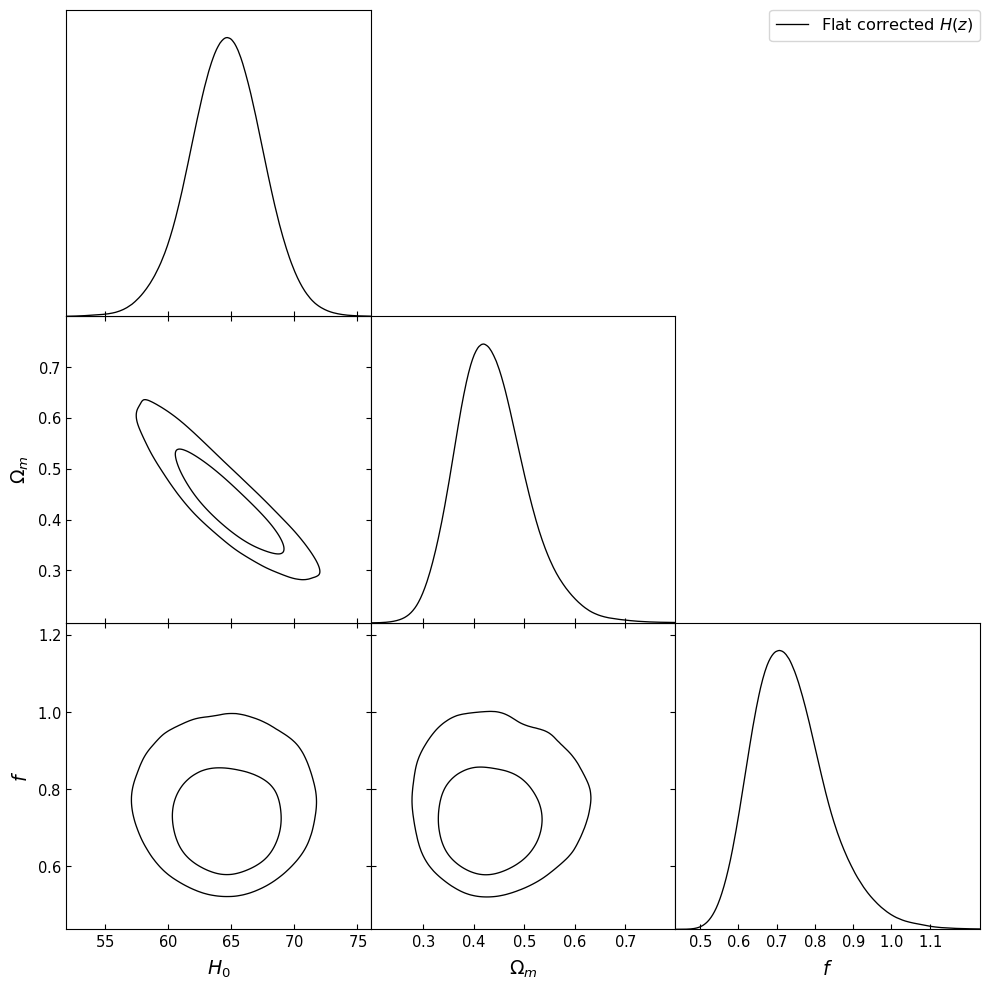

In [25]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixFf+'All-triangle.pdf')

In [23]:
samplesHzFf, gsamplesHzFf, parnamesFf, ndim = insertDerived(samplesHzFf, parnamesFf, parlabelsFf, 4, gsamplesHzFf, 1 - gsamplesHzFf.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [24]:
#Full spectrum
MC_result(samplesHzFf, ndim, parnamesFf)

MCMC result:
H0 = 63.35624 +8.59808 +18.26738 -8.73641 -12.53997 (median: 62.45097, ml: 0.00000)
wm = 0.35188 +0.07568 +0.13161 -0.07125 -0.11884 (median: 0.34787, ml: 0.00000)
f = 0.70137 +0.04954 +0.10802 -0.04940 -0.09087 (median: 0.69838, ml: 0.00000)
wl = 0.64812 +0.07125 +0.11884 -0.07568 -0.13161 (median: 0.65213, ml: 0.00000)


In [57]:
#D4000
MC_result(samplesHzFf, ndim, parnamesFf)

MCMC result:
H0 = 66.75390 +2.62290 +5.37137 -2.62440 -5.44203 (median: 66.77542, ml: 0.00000)
wm = 0.34485 +0.04514 +0.10501 -0.04643 -0.08553 (median: 0.34208, ml: 0.00000)
f = 0.46449 +0.06218 +0.14571 -0.06195 -0.10588 (median: 0.45751, ml: 0.00000)
wl = 0.65515 +0.04643 +0.08553 -0.04514 -0.10501 (median: 0.65792, ml: 0.00000)


In [28]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show
#g.export('fig/g'+prefixFf+'All-triangle_Wl.pdf')

<function matplotlib.pyplot.show(close=None, block=None)>

In [20]:
for i in range(ndimFf+1):
    for j in range(1,4):
        print(gsamplesHzFf.getInlineLatex(parnamesFf[i],limit=j))
        
print(gsamplesHzFf.getTable().tableTex())

H_0 = 67.1\pm 4.0
H_0 = 67^{+8}_{-8}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.333^{+0.040}_{-0.057}
\Omega_m = 0.333^{+0.11}_{-0.096}
\Omega_m = 0.33^{+0.17}_{-0.11}
f = 0.727^{+0.072}_{-0.11}
f = 0.73^{+0.20}_{-0.18}
f = 0.73^{+0.32}_{-0.20}
\Omega _{\Lambda} = 0.667^{+0.057}_{-0.040}
\Omega _{\Lambda} = 0.667^{+0.096}_{-0.11}
\Omega _{\Lambda} = 0.67^{+0.11}_{-0.17}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


In [21]:
print(types.ResultTable(ncol=1,results=gsamplesHzFf, paramList=parnamesFf, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


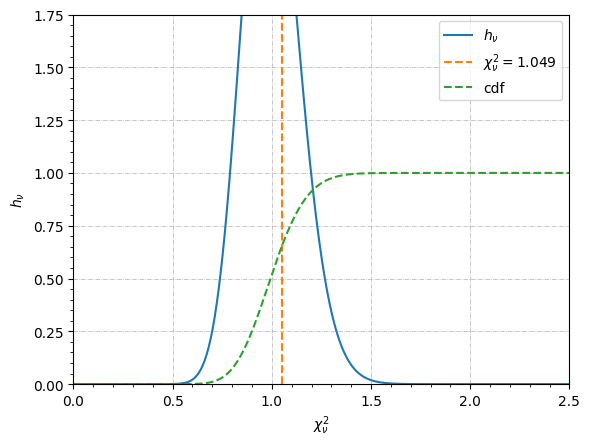

Probabilidade =  64.90842503163618
Chiv =  1.048900344527532


In [27]:
#Full spectrum 
chi2Ff=chi2Hz(free_par([66.75390,0.34485,0.70137], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='chi2FLCDM')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

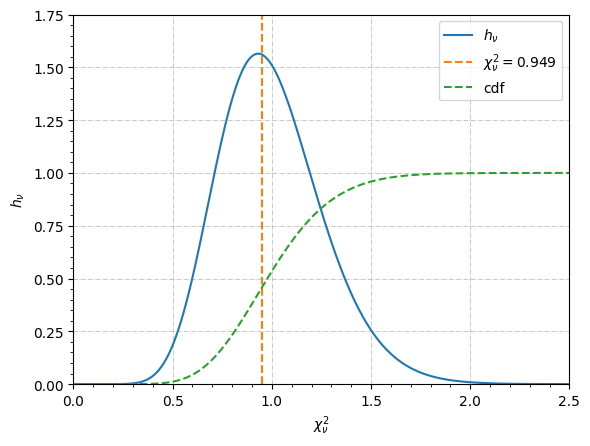

Probabilidade =  99.35129866448939
Chiv =  2.2937905185799643


In [63]:
#D4000
chi2Ff=chi2Hz(free_par([66.75390,0.34485,0.46449], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='chi2FLCDM')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(d_data-len(par_HzFf)), args=(d_data-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(d_data-len(par_HzFf)))

# Comparison between corrected and uncorrected Flat LCDM

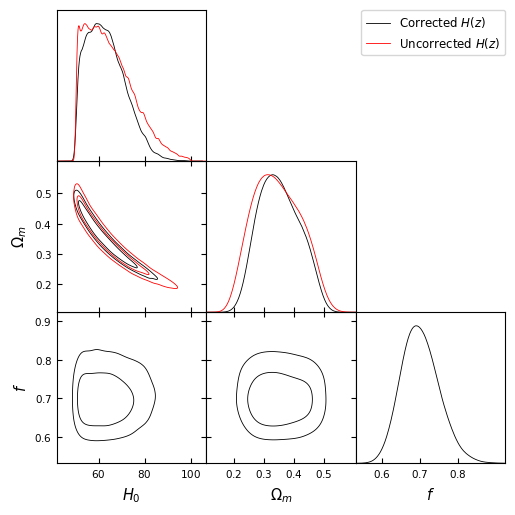

In [28]:
#Full spectrum
g = plots.getSubplotPlotter(subplot_size=1.75)
g.triangle_plot([gsamplesHzFf, gsamplesHzF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
pl.show()

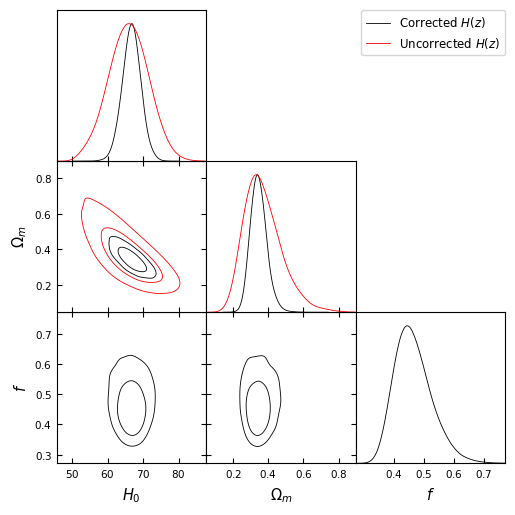

In [59]:
#D4000
g = plots.getSubplotPlotter(subplot_size=1.75)
g.triangle_plot([gsamplesHzFf, gsamplesHzF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
pl.show()

# Displacement in data no f

In [60]:
#Function to identify which model will be used
def free_parE(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f , e= theta
            return [h0, wm, wl, f, e]
        elif flat == True:
            h0, wm, f, e= theta
            return [h0, wm, 1-wm, f, e]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl, e = theta
            return [h0, wm, wl, 1, e]
        elif flat == True:
            h0, wm, e = theta
            return [h0, wm, 1-wm, 1, e]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2HzE(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[4] + (par[0]-par[4])*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHzE(par):
    for i in range(len(par)):
        if not priorArrayE[i][0] < par[i] < priorArrayE[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHzE(par):
    chi2 = chi2HzE(par)
    return -0.5*chi2 - ndata*np.log(par[3])

#?
def lnprobHzE(theta, freef, flat):
    par = free_parE(theta, freef, flat)
    
    lp = lnpriorHzE(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHzE(par)

#Minimize chi2
def find_bestfitE(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

priorArrayE = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2], [-50,50]])

## Flat LCDM without factor f

In [61]:
par_HzE = [69.1929957609451,0.2480895086492853, 5.]
ndimE = len(par_HzE)
prefixE = 'LcdmHz32CovCorr'
parlabelsE = ['H_0','\Omega_m', '\epsilon']
parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
parnamesE = ['H0','wm', 'e']

resultHzE = find_bestfit(lnprobHzE, par_HzE, parnamesE, freef=False, flat=True)
par_mlHzE = resultHzE['x']

Maximum likelihood result:
H0  =  67.9220083868301
wm  =  0.2585418562386453
e  =  -11.53060862031493
chi2min = 14.509563170806942
Total time: 0.033 seg


<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\O'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\e'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\O'
  parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\e'
  parlabtexE

In [62]:
samplerHzE = run_emcee(par_HzE, 100, lnprobHzE, False, True, 2.0, nstepHz)

 13%|█████████▊                                                                    | 631/5000 [00:04<00:30, 141.76it/s]


KeyboardInterrupt: 

In [ ]:
tauHzE = samplerHzE.get_autocorr_time()
print(tauHzE)

tauHzmaxE = np.amax(tauHzE)
r = nstepHz/tauHzmaxE
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzE = burninthin(samplerHzE, tauHzE)

In [ ]:
MC_result(samplesHzE, par_mlHzE, parnamesE)

In [ ]:
gsamplesHzE = MCSamples(samples=samplesHzE, names=parnamesE, labels=parlabelsE, ranges={'wm':(0, None)})
gsamplesHzE.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
samplesHzE, gsamplesHzE, parnamesE, ndim = insertDerived(samplesHzE, parnamesE, parlabelsE, 4, gsamplesHzE, 1 - gsamplesHzE.getParams().wm, 'wl', '\Omega_l')

In [ ]:
MC_result(samplesHzE, ndim, parnamesE)

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefixE+'All-triangle_Wk.pdf')

In [6]:
chi2E=chi2HzE(free_parE([70.60362,0.32969,3.18051], freef=False, flat=True))
plotChiDist(chi2E, len(par_HzE))
chivEperc, errF = quad(chiDist, 0, chi2E/(ndata-len(par_HzE)), args=(ndata-len(par_HzE)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2E/(ndata-len(par_HzE)))

NameError: name 'chi2HzE' is not defined

## Flat LCDM with factor f

In [ ]:
par_HzEf = [69.1929957609451,0.2480895086492853,.9, 5.]
ndimEf = len(par_HzEf)
prefixEf = 'LcdmHz32CovCorr'
parlabelsEf = ['H_0','\Omega_m', 'f', '\epsilon']
parlabtexEf = ['$H_0$','$\Omega_m$', 'f', '$\epsilon$']
parnamesEf = ['H0','wm', 'f','e']

resultHzEf = find_bestfit(lnprobHzE, par_HzEf, parnamesEf, freef=True, flat=True)
par_mlHzEf = resultHzEf['x']

In [ ]:
samplerHzEf = run_emcee(par_HzEf, 100, lnprobHzE, True, True, 2.0, nstepHz)

In [ ]:
tauHzEf = samplerHzEf.get_autocorr_time()
print(tauHzEf)

tauHzmaxEf = np.amax(tauHzEf)
r = nstepHz/tauHzmaxEf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzEf = burninthin(samplerHzEf, tauHzEf)

In [ ]:
MC_result(samplesHzEf, par_mlHzEf, parnamesEf)

In [ ]:
gsamplesHzEf = MCSamples(samples=samplesHzEf, names=parnamesEf, labels=parlabelsEf, ranges={'wm':(0, None)})
gsamplesHzEf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzEf], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$ and f'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
chi2Ef = chi2HzE(free_parE([71.28834, 0.32342, 0.72746, 3.75071], freef=True, flat=True))
plotChiDist(chi2Ef, len(par_HzEf))
chivEfperc, errF = quad(chiDist, 0, chi2Ef/(ndata-len(par_HzEf)), args=(ndata-len(par_HzEf)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2Ef/(ndata-len(par_HzEf)))

## OLCDM without factor f

In [ ]:
par_HzCE = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 5.]
ndimCE = len(par_HzCE)
prefixCE = 'LcdmHz32CovCorr'
parlabelsCE = ['H_0','\Omega_m', '\Omega_l', '\epsilon']
parlabtexCE = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$']
parnamesCE = ['H0','wm', 'wl', 'e']

resultHzCE = find_bestfitE(lnprobHzE, par_HzCE, parnamesCE, freef=False, flat=False)
par_mlHzCE = resultHzCE['x']

## OLCDM with factor f

In [ ]:
par_HzCEf = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9, 5.]
ndimCEf = len(par_HzCEf)
prefixCEf = 'LcdmHz32CovCorr'
parlabelsCEf = ['H_0','\Omega_m', '\Omega_l', 'f' '\epsilon']
parlabtexCEf = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$', '$\epsilon$']
parnamesCEf = ['H0','wm', 'wl', 'f', 'e']

resultHzCEf = find_bestfitE(lnprobHzE, par_HzCEf, parnamesCEf, freef=True, flat=False)
par_mlHzCEf = resultHzCEf['x']